In [3]:
import scanpy as sc
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


import random

In [56]:
def train_test_validation_split(df, age, test_size=0.3, validation_size=0.1):
    all_numbers = set(range(int(len(df)/10)))
    random_numbers = random.sample(sorted(all_numbers), int(len(df)/10*test_size))
    all_numbers -= set(random_numbers)  # 從所有數字中移除已經選取的數字
    
    X_test = pd.DataFrame()
    y_test = pd.Series(dtype='int')
    for i in random_numbers:
        X_test = pd.concat([X_test, df.iloc[i*10:i*10+10]])
        y_test = pd.concat([y_test, age.iloc[i*10:i*10+10]])
        df.drop(df.index[i*10: i*10+10])
        age.drop(age.index[i*10: i*10+10])
        
    
    random_validation = random.sample(sorted(all_numbers), int(len(df)/10*validation_size))
    X_validation = pd.DataFrame()
    y_validation = pd.Series(dtype='int')
    for i in random_validation:
        X_validation = pd.concat([X_validation, df.iloc[i*10:i*10+10]])
        y_validation = pd.concat([y_validation, age.iloc[i*10:i*10+10]])
        df.drop(df.index[i*10: i*10+10])
        age.drop(age.index[i*10: i*10+10])
    
    X_train = df
    y_train = age
    
    
    return X_train, X_test, y_train, y_test, X_validation, y_validation

def train_test_split(df, age, test_size=0.3):
    all_numbers = set(range(int(len(df)/10)))
    random_numbers = random.sample(sorted(all_numbers), int(len(df)/10*test_size))
    all_numbers -= set(random_numbers)  # 從所有數字中移除已經選取的數字
    
    X_test = pd.DataFrame()
    y_test = pd.Series(dtype='int')
    for i in random_numbers:
        X_test = pd.concat([X_test, df.iloc[i*10:i*10+10]])
        y_test = pd.concat([y_test, age.iloc[i*10:i*10+10]])
        df.drop(df.index[i*10: i*10+10])
        age.drop(age.index[i*10: i*10+10])
    
    X_train = df
    y_train = age
    
    
    return X_train, X_test, y_train, y_test

def XGBR(X_train, X_test, y_train, y_test, n_estimators = 45, max_depth = 4):
    # n_jobs=-1處理器全開
    xgbrModel = xgb.XGBRegressor(n_estimators = n_estimators, n_jobs=-1, max_depth = max_depth,
                                colsample_bytree = 1, gamma = 0.1, min_child_weight = 1,
                                subsample = 0.8, eval_metric="rmse", reg_alpha=0.1, reg_lambda=0.1)  
    # 創建k折交叉驗證對象
    kf = KFold(n_splits=10, shuffle=True)

    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(xgbrModel, X_train, y_train, cv=kf)
    print('Cross-validation scores: ', scores)

    # train model with early stopping
    eval_set = [(X_test, y_test)]
    xgbrModel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = xgbrModel.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',xgbrModel.score(X_train,y_train))
    print('Test Set score: ',xgbrModel.score(X_test,y_test))
    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')
    plt.scatter(y_test, y_pred, s=10, label='True')

    # 繪製對角線
    min_val = np.min([np.min(y_test), np.min(y_pred)])  # 找到最小值
    max_val = np.max([np.max(y_test), np.max(y_pred)])  # 找到最大值
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線

    plt.xlabel('Chronological Age',fontsize = 22)
    plt.ylabel('Predicted Age',fontsize = 22)
    plt.title('Healthy',fontsize = 24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig("Healthy_XBGR.png", dpi=900, bbox_inches='tight')
    plt.show()
   
    print('特徵重要程度: ',xgbrModel.feature_importances_)
    
    return xgbrModel

def RandomForestRegression(X_train, X_test, y_train, y_test, n_estimators=45):
    # n_jobs=-1處理器全開
    RFR = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)# , random_state=0
    # 創建k折交叉驗證對象
    kf = KFold(n_splits=10, shuffle=True)
    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(RFR, X_train, y_train, cv=kf)
    print('Cross-validation scores: ', scores)

    # train model
    RFR.fit(X_train, y_train)

    y_pred = RFR.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',RFR.score(X_train,y_train))
    print('Test Set score: ',RFR.score(X_test,y_test))

    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')

    plt.scatter(y_test, y_pred, s=10, label='True')
    # 繪製對角線
    min_val = np.min([np.min(y_test), np.min(y_pred)])  # 找到最小值
    max_val = np.max([np.max(y_test), np.max(y_pred)])  # 找到最大值
    
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線
    plt.xlabel('Chronological Age',fontsize = 22)
    plt.ylabel('Predicted Age',fontsize = 22)
    plt.title('Chronological vs Predicted Ages',fontsize = 24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    
    
    print('特徵重要程度: ',RFR.feature_importances_)
    return RFR

# Linear Regression
def LR(X_train, X_test, y_train, y_test):
    # n_jobs=-1處理器全開
    model = LinearRegression(fit_intercept=True, n_jobs=-1)  
    # 創建k折交叉驗證對象
    kf = KFold(n_splits=10, shuffle=True)

    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(model, X_train, y_train, cv=kf)
    print('Cross-validation scores: ', scores)


    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',model.score(X_train,y_train))
    print('Test Set score: ',model.score(X_test,y_test))
    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')
    plt.scatter(y_test, y_pred, s=10, label='True')

    # 繪製對角線
    min_val = np.min([np.min(y_test), np.min(y_pred)])  # 找到最小值
    max_val = np.max([np.max(y_test), np.max(y_pred)])  # 找到最大值
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線

    plt.xlabel('Chronological Age',fontsize = 22)
    plt.ylabel('Predicted Age',fontsize = 22)
    plt.title('Chronological vs Predicted Ages',fontsize = 24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
   
    print('特徵係數: ',model.coef_)

def validation_result(model, X_validation, y_validation):
    #Validataion
    y_pred_valid = model.predict(X_validation)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse_valid = mean_squared_error(y_validation, y_pred_valid)
    print(f'Mean Squared Error (MSE): {mse_valid}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae_valid = mean_absolute_error(y_validation, y_pred_valid)
    print(f'Mean Absolute Error (MAE): {mae_valid}')

    print('Validataion Set score: ',model.score(X_validation,y_validation))

    # 計算皮爾森相關係數
    corr_valid, _ = pearsonr(y_validation, y_pred_valid)
    print(f'Pearson correlation: {corr_valid}')
    plt.scatter(y_validation, y_pred_valid, s=10, label='True')

    # 繪製對角線
    min_val = np.min([np.min(y_validation), np.min(y_pred_valid)])  # 找到最小值
    max_val = np.max([np.max(y_validation), np.max(y_pred_valid)])  # 找到最大值
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', label='Diagonal line')  # 繪製對角線

    plt.xlabel('Chronological Age',fontsize = 22)
    plt.ylabel('Predicted Age',fontsize = 22)
    plt.title('SLE',fontsize = 24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig("SLE_XBGR.png", dpi=900, bbox_inches='tight')
    plt.show()

# GSE174188

In [57]:
with open("data_augmentation_GSE174188.csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)
with open("data_augmentation_GSE174188_SLE.csv", 'r') as file:
    df_SLE = pd.read_csv(file, index_col = 0)    
    
age = df["age"].astype(int)
df = df.drop(columns = "age", axis = 1)

age_SLE = df_SLE["age"].astype(int)
df_SLE = df_SLE.drop(columns = "age", axis = 1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df, age, 0.3)

Cross-validation scores:  [0.87297351 0.89163213 0.92881856 0.8787401  0.90957743 0.94620059
 0.95086874 0.95632557 0.88416195 0.90911381]
Mean Squared Error (MSE): 1.3594472337179468
Mean Absolute Error (MAE): 0.8815531130190248
Train Set score:  0.9915602608826296
Test Set score:  0.9887271989287214
Pearson correlation: 0.9943887960294181


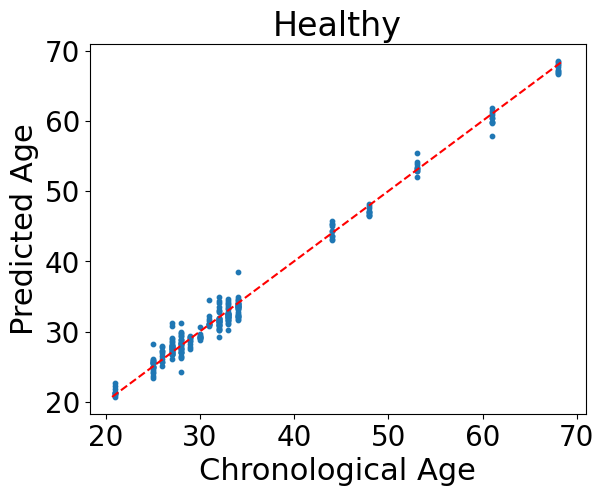

特徵重要程度:  [0.1301368  0.18673365 0.14241849 0.21884371 0.09843707 0.15270908
 0.01178698 0.01006474 0.01322919 0.00795602 0.02176066 0.00592364]


In [59]:
xgbrModel = XGBR(X_train, X_test, y_train, y_test, 45, 4)

Mean Squared Error (MSE): 560.4877303554118
Mean Absolute Error (MAE): 19.695970258405133
Validataion Set score:  -1.8209678672398755
Pearson correlation: 0.10457068896001967


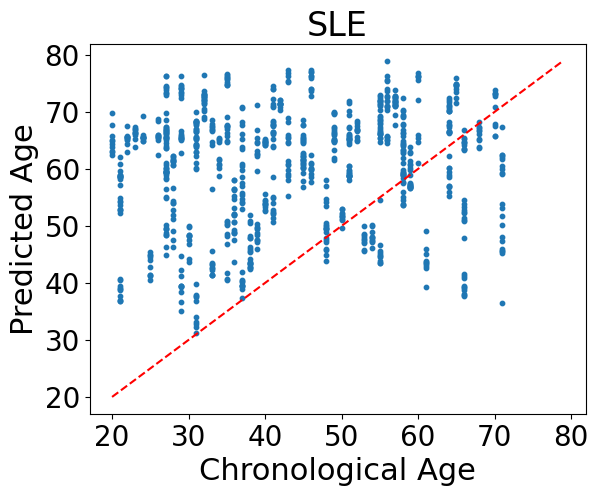

In [60]:
validation_result(xgbrModel, df_SLE, age_SLE)

# GSE165080 + GSE149689(BBKNN)

In [ ]:
with open("data_augmentation_merge(GSE165080,GSE149689).csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)
with open('data_augmentation_GSE149689.csv', 'r') as file:
    df_GSE149689 = pd.read_csv(file, index_col = 0)
    
age = df["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df = df.drop(columns = "age", axis = 1)

age_GSE149689 = df_GSE149689['age'].astype(int)
df_GSE149689 = df_GSE149689.drop(columns = 'age', axis = 1)
df = df.drop(df_GSE149689.index)
age = age.drop(age_GSE149689.index)

X_train, X_test, y_train, y_test, X_validation, y_validation = train_test_validation_split(df, age, 0.3, 0.1)

In [ ]:
xgbrModel = XGBR(X_train, X_test, y_train, y_test, "Merge(GSE165080,GSE149689)", 45, 4)

# GSE165080 + GSE149689(Azimuth + BBKNN)

In [46]:
with open("data_augmentation_combine_GSE165080_GSE149689.csv", "r") as file:
    df = pd.read_csv(file, index_col = 0)
with open('data_augmentation_GSE149689.csv', 'r') as file:
    df_GSE149689 = pd.read_csv(file, index_col = 0)
    
age = df['age'].astype(int)
df = df.drop(columns = 'age', axis = 1)

age_GSE149689 = df_GSE149689['age'].astype(int)
df_GSE149689 = df_GSE149689.drop(columns = 'age', axis = 1)
df = df.drop(df_GSE149689.index)
age = age.drop(age_GSE149689.index)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df, age, 0.3)

Cross-validation scores:  [0.97817807 0.98204545 0.83384814 0.89806118 0.9999626  0.89142899
 0.99139742 0.99605255 0.99560269 0.78281005]
Mean Squared Error (MSE): 14.355269117018906
Mean Absolute Error (MAE): 3.4847620646158854
Train Set score:  0.9997228406535476
Test Set score:  0.8380984686050499
Pearson correlation: 0.9914593463529547


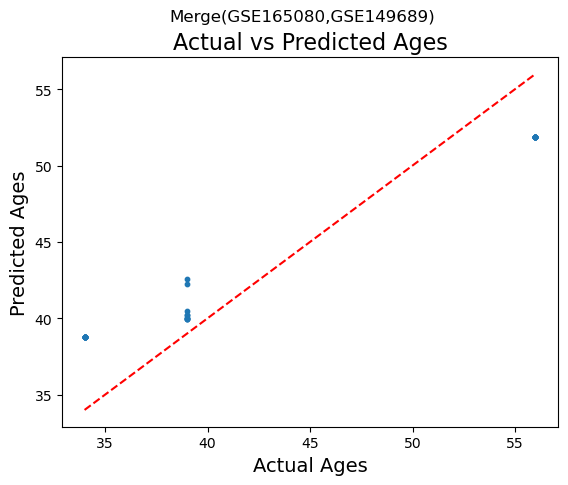

特徵重要程度:  [1.8893000e-02 3.1268504e-01 2.7313111e-03 4.1355726e-01 1.8790395e-03
 2.4234056e-01 1.4535321e-03 3.1638431e-04 3.2474851e-04 5.2889735e-03
 0.0000000e+00 5.3022965e-04]


In [81]:
xgbrModel = XGBR(X_train, X_test, y_train, y_test, "Merge(GSE165080,GSE149689)", 45, 4)

# GSE165080 + GSE149689 + GSE174188(BBKNN)

Train >> GSE174188

Test >> GSE174188

Validation >> GSE165080 + GSE149689

In [155]:
with open("data_augmentation_merge(GSE165080,GSE149689,GSE174188).csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)
with open("data_augmentation_combine_GSE165080_GSE149689.csv", 'r') as file:
    df_two_dataset = pd.read_csv(file, index_col = 0)
age = df["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df = df.drop(columns = "age", axis = 1)

df = df.drop(df_two_dataset.index)
age = age.drop(df_two_dataset["age"].index)
age_two_dataset = df_two_dataset["age"].astype(int)
df_two_dataset = df_two_dataset.drop(columns = 'age', axis=1)

In [151]:
X_train, X_test, y_train, y_test, X_validation, y_validation= train_test_validation_split(df, age, 0.3, 0.1)

In [158]:
X_train, X_test, y_train, y_test= train_test_split(df, age, 0.3)

Cross-validation scores:  [0.95880118 0.9402924  0.92332947 0.94787191 0.92119867 0.88052296
 0.91633779 0.94006958 0.96439136 0.93724069]
Mean Squared Error (MSE): 79.31155972457361
Mean Absolute Error (MAE): 7.075054284800654
Train Set score:  0.9950492812888427
Test Set score:  0.20954415964619166
Pearson correlation: 0.6275415539425482


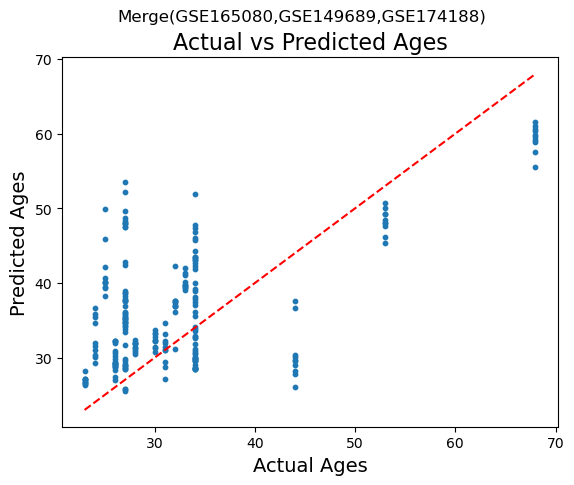

特徵重要程度:  [0.10231683 0.12837248 0.11948252 0.30585015 0.12091098 0.17486413
 0.01038189 0.01054399 0.00594462 0.00771009 0.00791245 0.00570988]


In [171]:
xgbrModel = XGBR(X_train, X_test, y_train, y_test, "Merge(GSE165080,GSE149689,GSE174188)", 45, 4) 

Mean Squared Error (MSE): 265.08160855735
Mean Absolute Error (MAE): 12.706182327270508
Validataion Set score:  -1.2813403429239503
Pearson correlation: -0.5438945730787834


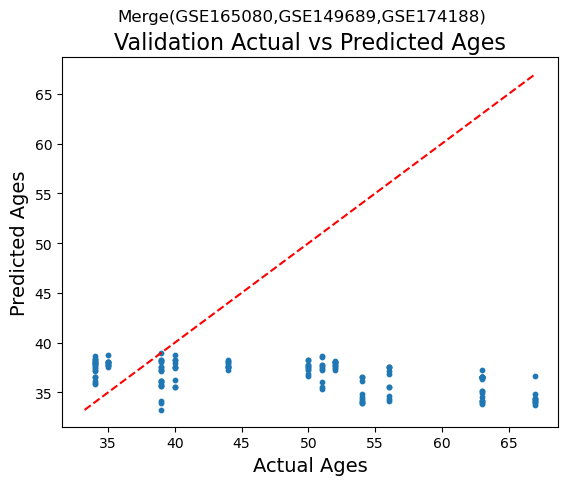

In [154]:
# After Azimuth
validation_result(xgbrModel, df_two_dataset, age_two_dataset, "Merge(GSE165080,GSE149689,GSE174188)")